# Reading/Writing interchange with ORSO data files and the ORSO model language

The [Open Reflectometry Standards Organisation](https://www.reflectometry.org/) is an international, open effort to improve the scientific techniques of neutron and X-ray reflectometry. One aspect of ORSO is to provide a standardised reduced data file that is designed to be Findable Accessible Interoperable Reusable (FAIR), which is vital for reproducible research. The Python functionality for reading/writing such files is provided by [orsopy](https://orsopy.readthedocs.io/en/latest/index.html). Another aspect of this effort is the desire to have a [simple model language](https://www.reflectometry.org/advanced_and_expert_level/file_format/simple_model) that permits a description of the interfacial model used for analysis. This description should allow others to recreate the same analysis setup. Placing the data and model in the electronic supporting information of a paper helps with reproducible research.

Currently `refnx` is able to read/write ORSO data files, and can read/write model language files for simple slab models. Here we show a simple example of working with both. The example is simulated reflectivity from a Nickel thin film.

Let's grab the example ORT dataset first.

In [1]:
import urllib.request
import shutil
url = "https://github.com/refnx/refnx-testdata/raw/refs/heads/master/data/dataset/Ni_example.ort"
with (urllib.request.urlopen(url, timeout=5) as response, open("Ni_example.ort", 'wb') as f):
    shutil.copyfileobj(response, f)

In [2]:
# load the example ORSO dataset
from refnx.dataset import load_data, OrsoDataset

# data = load_data("Ni_example.ort")
data = OrsoDataset("Ni_example.ort")

In [3]:
# let's create a simple Structure and Model to describe the system
import numpy as np
from refnx.reflect import SLD, ReflectModel, MaterialSLD

air = SLD(0, name="air")
ni = MaterialSLD("Ni", 8.9, name="Ni")
sio2 = SLD(3.47, name="SiO2")
si = SLD(2.07, name="Si")

s = air | ni(950, 4) | sio2(10, 4) | si(np.inf, 4)
model = ReflectModel(s, bkg=1e-7)

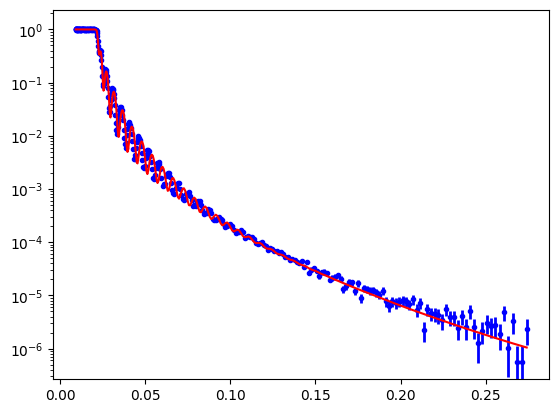

In [4]:
# create an Objective to do the fit
import matplotlib.pyplot as plt
from refnx.analysis import Objective
obj = Objective(model, data)
obj.plot();
plt.yscale('log')

In [5]:
# now do a fit, but first let's modify the parameters we'll vary
s[1].thick.setp(vary=True, bounds=(950, 1050))    # Ni film
s[1].sld.density.setp(vary=True, bounds=(8.5, 8.9))
s[1].rough.setp(vary=True, bounds=(3, 6))
s[2].thick.setp(vary=True, bounds=(5, 15))        # SiO2 layer
s[2].rough.setp(vary=True, bounds=(3, 6))
s[-1].rough.setp(vary=True, bounds=(3, 6))        # backing medium
model.bkg.setp(vary=True, bounds=(1e-7, 5e-6))

In [6]:
from refnx.analysis import CurveFitter
fitter = CurveFitter(obj)
fitter.fit(method='differential_evolution');

-2464.181674102402: : 15it [00:00, 23.42it/s] 


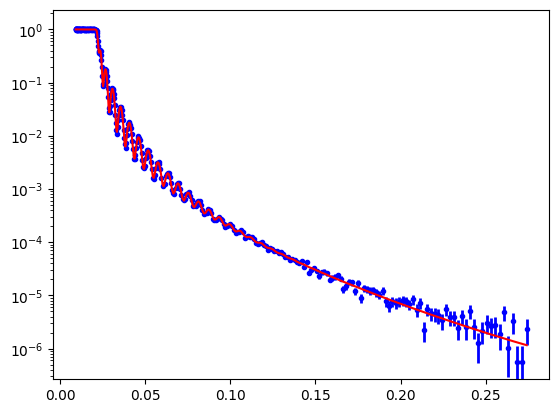

In [7]:
obj.plot();
plt.yscale('log')

### output to ORSO model language file

In [8]:
model_orso = s.to_orso()
model_orso_yaml = model_orso.to_yaml()
print(model_orso_yaml)
with open("ni_orso_example_model.yml", "wt") as f:
    f.write(model_orso_yaml)

stack: air | Ni | SiO2 | Si
layers:
  air:
    thickness: 0.0
    roughness: 0.0
    material:
      sld: {real: 0.0, imag: 0.0}
  Ni:
    thickness: 999.9426602091901
    roughness: 4.0562638621344105
    material:
      formula: Ni
      mass_density: 8.89179694851672
  SiO2:
    thickness: 6.845493490619118
    roughness: 4.055938080912933
    material:
      sld: {real: 3.4700000000000002e-06, imag: 0.0}
  Si:
    thickness: .inf
    roughness: 3.1113891758058667
    material:
      sld: {real: 2.0699999999999997e-06, imag: 0.0}
globals:
  roughness: {magnitude: 0.3, unit: nm}
  length_unit: angstrom
  mass_density_unit: g/cm^3
  number_density_unit: 1/nm^3
  sld_unit: 1/angstrom^2
  magnetic_moment_unit: muB
reference: ORSO model language | 1.0



### store model in ORSO file

In [9]:
ds = data.orso[0]
ds.info.data_source.sample.model = model_orso
ds.save("Ni_example.ort")

### read ORSO model language file

In [10]:
import yaml
from refnx.reflect import Structure
from orsopy.fileio.model_language import SampleModel

# parse yaml into dict and reconstruct SampleModel
with open("ni_orso_example_model.yml", "rt") as f:
    dct = yaml.safe_load(f)

sm = SampleModel.from_dict(dct)

# finally create a Structure from the ORSO SampleModel
s2 = Structure.from_orso(sm)
print(s2)

________________________________________________________________________________
Structure:                
solvent: None
reverse structure: False
contract: 0

________________________________________________________________________________
Parameters:      'air'     
<Parameter: 'air - thick' , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:       ''       
<Parameter:   ' - sld'    , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:   ' - isld'   , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter: 'air - rough' , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'air - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:      'Ni'      
<Parameter: 'Ni - thick'  , value=999.943  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:      